# Note on performance
In **section 3-1**, the use of the **SOAP descriptor** in GPR can be computationally intensive.

On **high-performance computing (HPC)** or **GPU** systems, the SOAP-based GPR runs significantly faster.

In this Colab environment, you can switch to a **GPU** by going to

`Runtime → Change runtime type → Hardware accelerator → T4 GPU`

In [1]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [2]:
try:
    import numpy as np
    print("successfully imported numpy")
    print(np.__version__)
except ImportError:
    !! pip install numpy --user --upgrade
    print("completed installing numpy")

successfully imported numpy
1.26.4


In [3]:
try:
    from matplotlib import pyplot as plt
    print("successfully imported matplotlib")
except ImportError:
    !! pip install matplotlib --user --upgrade
    print("completed installing matplotlib")

successfully imported matplotlib


In [4]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 2.6.5
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase
Required-by: 


In [5]:
import os, sys, site
sys.path.append(site.USER_SITE)

import aenet_gpr
print(aenet_gpr.__version__)

2.6.5


In [6]:
from IPython.display import Image

try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")
    
    import ase.io
    print("successfully imported ase")

successfully imported ase


# 1. Prepare training/test data

We are using train/test HSE06 data of Li/EC interface prepared in `aenet-gpr/example/3_Li-EC/`

In [7]:
import os.path

! rm -rf 3_Li-EC
! mkdir 3_Li-EC
    
if os.path.isfile("../example/3_Li-EC/train_set_tutorial.zip"):
    ! unzip -oq ../example/3_Li-EC/train_set_tutorial.zip -d ./3_Li-EC/
    print("number of train data:")
    ! find ./3_Li-EC/train_set_tutorial/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/train_set_tutorial.zip
    ! unzip -oq train_set_tutorial.zip -d ./3_Li-EC/
    ! rm train_set_tutorial.zip
    print("number of train data:")
    ! find ./3_Li-EC/train_set_tutorial/ -type f | wc -l

--2025-10-19 17:05:28--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/train_set_tutorial.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/train_set_tutorial.zip [following]
--2025-10-19 17:05:28--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/train_set_tutorial.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74855 (73K) [application/zip]
Saving to: ‘train_set_tutorial.zip’

train_set_tutorial. 100%[===================>]  73.10K  --.-KB/s    in 0.001s  

2025-

In [8]:
if os.path.isfile("../example/3_Li-EC/test_set_tutorial.zip"):
    ! unzip -oq ../example/3_Li-EC/test_set_tutorial.zip -d ./3_Li-EC/
    print("number of test data:")
    ! find ./3_Li-EC/test_set_tutorial/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/test_set_tutorial.zip
    ! unzip -oq test_set_tutorial.zip -d ./3_Li-EC/
    ! rm test_set_tutorial.zip
    print("number of test data:")
    ! find ./3_Li-EC/test_set_tutorial/ -type f | wc -l

--2025-10-19 17:05:28--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/test_set_tutorial.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/test_set_tutorial.zip [following]
--2025-10-19 17:05:29--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/test_set_tutorial.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149388 (146K) [application/zip]
Saving to: ‘test_set_tutorial.zip’

test_set_tutorial.z 100%[===================>] 145.89K  --.-KB/s    in 0.003s  

2025-10

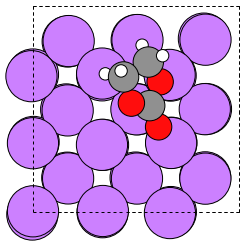

In [9]:
atoms = ase.io.read("./3_Li-EC/test_set_tutorial/file_0000.xsf")
ase.io.write('Li-EC.png', atoms)
Image("Li-EC.png")

# 2-1. Train–Test with default Cartesian fingerprint

In [10]:
! rm -f train.in

if os.path.isfile("../example/3_Li-EC/train.in"):
    ! cp ../example/3_Li-EC/train.in .
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/train.in

--2025-10-19 17:05:30--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/train.in
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/train.in [following]
--2025-10-19 17:05:30--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/train.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587 [text/plain]
Saving to: ‘train.in’

train.in            100%[===================>]     587  --.-KB/s    in 0s      

2025-10-19 17:05:30 (10.8 MB/s) - ‘train.in’ saved [587/587]



In [11]:
! cat train.in

# File path
Train_file ./3_Li-EC/train_set_tutorial/file_*.xsf
Test_file ./3_Li-EC/test_set_tutorial/file_*.xsf

# Train model save (default: False)
# Train_model_save True

# File format (default: xsf)
File_format xsf

# Descriptor (default: cartesian coordinates)
Descriptor cart

# Kernel parameter
# scale 0.4
# weight 1.0

# Data process (default: batch, 25)
data_process batch
batch_size 25

# Flags for xsf file writing (default: False)
Train_write False
Test_write False
# Additional_write True

# Data augmentation parameter (default: 0.055, 25)
# Disp_length 0.05
# Num_copy 3


In [12]:
! python -m aenet_gpr train.in

aenet-GPR: surrogate GPR for GPR-ANN indirect force training

2025-10-19 17:05:34.

Developed by In Won Yeu

This program performs three main steps:
1. Train: Generates a GPR model using the provided structure, energy, and force data.
2. Test: Uses the generated GPR model to predict values for the test set structures.
3. Augmentation: Performs data augmentation in xsf file format, compatible with aenet-(PyTorch),
supporting a GPR-ANN training in conjunction with aenet-(PyTorch).

Each of these steps is executed once the input file (train.in) contains the keywords:
Train_file [train file path]
Test_file [test file path]
Additional_write [True]


Train

Read reference training data

Time needed for reading data:            0.077833 s
Maximum CPU memory used:             0.411930 GB
Maximum GPU memory used:             0.000000 GB
Energy data size: (30,)  # (N_data, )
Force data size: (30, 46, 3)  # (N_data, N_atom, 3)
----------------------------------------------------------------------

# 2-2. Visualize the results

In [13]:
energy_test_gpr = np.load("./energy_test_gpr.npy")
energy_test_reference = np.load("./energy_test_reference.npy")

force_test_gpr = np.load("./force_test_gpr.npy")
force_test_reference = np.load("./force_test_reference.npy")

unc_e_test_gpr = np.load("./unc_e_test_gpr.npy")
unc_f_test_gpr = np.load("./unc_f_test_gpr.npy")

In [14]:
diff_per_atom = (energy_test_reference - energy_test_gpr) / 46

print(diff_per_atom.min(), diff_per_atom.max())

-0.007817935342324705 0.012918689117372118


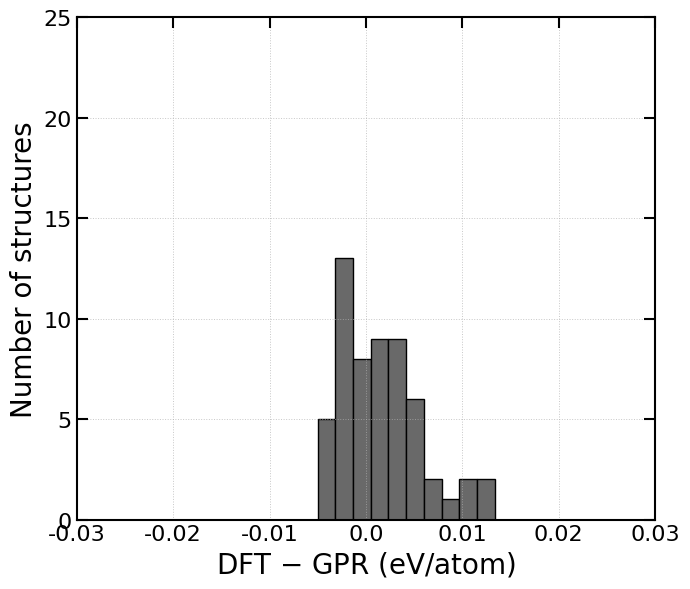

In [15]:
fig = plt.figure(figsize=(7, 6))
ax2 = fig.subplots()

font_x = {'size': 20, 'color': 'black'}
font_y = {'size': 20, 'color': 'black'}
font_tick = {'size': 16, 'color': 'black'}


# The second plot
counts, bins = np.histogram(diff_per_atom, bins=30, range=(-0.005, 0.05))

ax2.hist(bins[:-1], bins, weights=counts, facecolor='dimgray', alpha=1.0, edgecolor='black')

ax2.set_xlabel("DFT $-$ GPR (eV/atom)", fontdict=font_x)
ax2.set_xlim([-0.03, 0.03])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([-0.03, 0.03])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Number of structures", fontdict=font_y)
ax2.set_ylim([0, 25])
y_labels = [int(label) for label in ax2.get_yticks()]
ax2.set_yticks(y_labels)
ax2.set_ylim([0, 25])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=False, top=True, left=True, right=True)
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)

ax2.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)

fig.tight_layout()
plt.show()

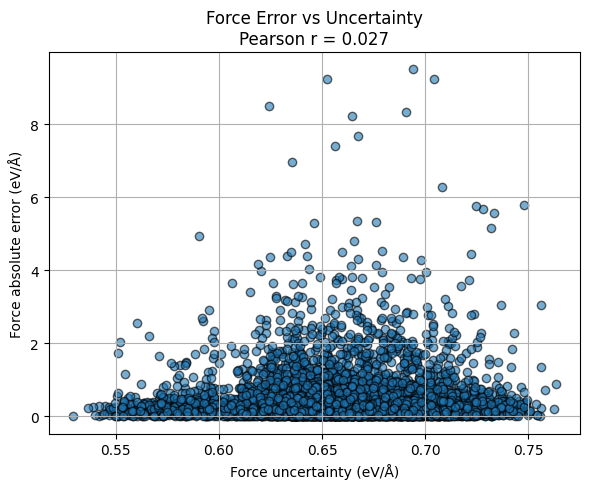

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- Force error vs uncertainty ---
force_error = np.abs(force_test_gpr - force_test_reference).reshape(-1)
unc_f = unc_f_test_gpr.reshape(-1)

r_force, _ = pearsonr(force_error, unc_f)

plt.figure(figsize=(6, 5))
plt.scatter(unc_f, force_error, alpha=0.6, edgecolors='k')
plt.xlabel("Force uncertainty (eV/Å)")
plt.ylabel("Force absolute error (eV/Å)")
plt.title(f"Force Error vs Uncertainty\nPearson r = {r_force:.3f}")
plt.grid(True)
# plt.xlim(0.0, 1.0)
# plt.ylim(0, 2.0)
plt.tight_layout()
plt.show()

# 3-1. Train–Test–Augment with SOAP fingerprint

In [19]:
! rm -f train_soap.in

if os.path.isfile("../example/3_Li-EC/train_soap.in"):
    ! cp ../example/3_Li-EC/train_soap.in .
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/train_soap.in

--2025-10-19 17:07:20--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/3_Li-EC/train_soap.in
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/train_soap.in [following]
--2025-10-19 17:07:20--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/3_Li-EC/train_soap.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077 (1.1K) [text/plain]
Saving to: ‘train_soap.in’

train_soap.in       100%[===================>]   1.05K  --.-KB/s    in 0s      

2025-10-19 17:07:20 (18.1 MB/s) - ‘train_soap.

In [20]:
! cat train_soap.in

# File path
Train_file ./3_Li-EC/train_set_tutorial/file_*.xsf
Test_file ./3_Li-EC/test_set_tutorial/file_*.xsf

# File format (default: xsf)
File_format xsf

# Descriptor (default: cartesian coordinates)
Descriptor soap

# Soap parameters
soap_r_cut 5.0
soap_n_max 6
soap_l_max 4
soap_centers [[2.20113706670393, 2.328998192856251, 6.952547732109352], [2.20113706670393, 2.328998192856251, 11.895790642109352], [2.20113706670393, 6.760484232856251, 6.952547732109352], [2.20113706670393, 6.760484232856251, 11.895790642109352], [6.63924050670393, 2.328998192856251, 6.952547732109352], [6.63924050670393, 2.328998192856251, 11.895790642109352], [6.63924050670393, 6.760484232856251, 6.952547732109352], [6.63924050670393, 6.760484232856251, 11.895790642109352]]
soap_n_jobs 32

# Kernel parameter
# scale 0.4
# weight 1.0

# Data process (default: batch, 25)
data_process batch
batch_size 10

# Flags for xsf file writing (default: False)
Train_write False
Test_write False
Additional_write True

# 

In [21]:
! rm -rf additional_xsf/
! python -m aenet_gpr train_soap.in

aenet-GPR: surrogate GPR for GPR-ANN indirect force training

2025-10-19 17:07:24.

Developed by In Won Yeu

This program performs three main steps:
1. Train: Generates a GPR model using the provided structure, energy, and force data.
2. Test: Uses the generated GPR model to predict values for the test set structures.
3. Augmentation: Performs data augmentation in xsf file format, compatible with aenet-(PyTorch),
supporting a GPR-ANN training in conjunction with aenet-(PyTorch).

Each of these steps is executed once the input file (train.in) contains the keywords:
Train_file [train file path]
Test_file [test file path]
Additional_write [True]


Train

Read reference training data

Time needed for reading data:            0.076803 s
Maximum CPU memory used:             0.411224 GB
Maximum GPU memory used:             0.000000 GB
Energy data size: (30,)  # (N_data, )
Force data size: (30, 46, 3)  # (N_data, N_atom, 3)
----------------------------------------------------------------------

# 3-2. Visualize the test results

In [22]:
energy_test_gpr = np.load("./energy_test_gpr.npy")
energy_test_reference = np.load("./energy_test_reference.npy")

force_test_gpr = np.load("./force_test_gpr.npy")
force_test_reference = np.load("./force_test_reference.npy")

unc_e_test_gpr = np.load("./unc_e_test_gpr.npy")
unc_f_test_gpr = np.load("./unc_f_test_gpr.npy")

In [23]:
diff_per_atom = (energy_test_reference - energy_test_gpr) / 46

print(diff_per_atom.min(), diff_per_atom.max())

-0.0027989477913133273 0.012551811322776737


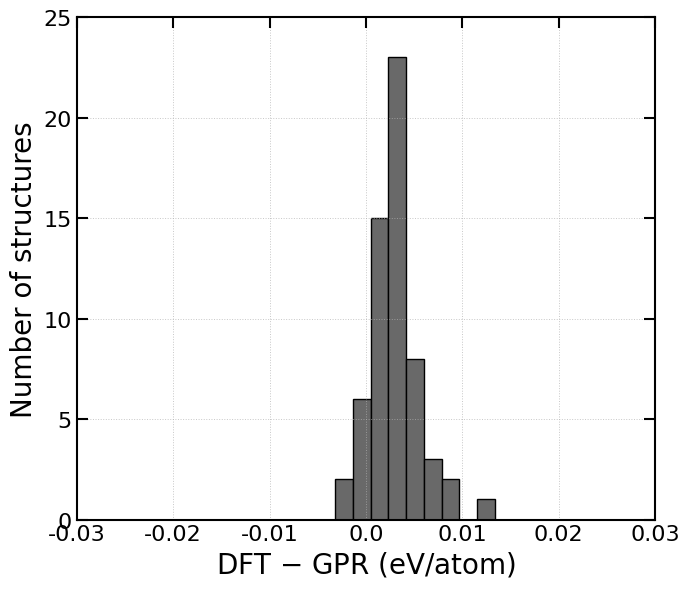

In [24]:
fig = plt.figure(figsize=(7, 6))
ax2 = fig.subplots()

font_x = {'size': 20, 'color': 'black'}
font_y = {'size': 20, 'color': 'black'}
font_tick = {'size': 16, 'color': 'black'}


# The second plot
counts, bins = np.histogram(diff_per_atom, bins=30, range=(-0.005, 0.05))

ax2.hist(bins[:-1], bins, weights=counts, facecolor='dimgray', alpha=1.0, edgecolor='black')

ax2.set_xlabel("DFT $-$ GPR (eV/atom)", fontdict=font_x)
ax2.set_xlim([-0.03, 0.03])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([-0.03, 0.03])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Number of structures", fontdict=font_y)
ax2.set_ylim([0, 25])
y_labels = [int(label) for label in ax2.get_yticks()]
ax2.set_yticks(y_labels)
ax2.set_ylim([0, 25])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=False, top=True, left=True, right=True)
ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)

ax2.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.7)

fig.tight_layout()
plt.show()

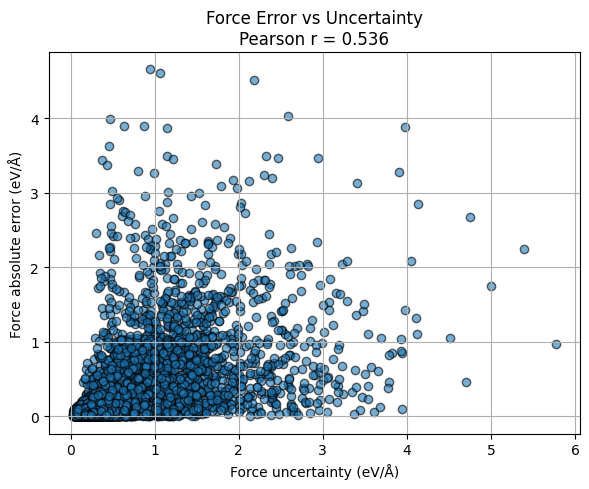

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# --- Force error vs uncertainty ---
force_error = np.abs(force_test_gpr - force_test_reference).reshape(-1)
unc_f = unc_f_test_gpr.reshape(-1)

r_force, _ = pearsonr(force_error, unc_f)

plt.figure(figsize=(6, 5))
plt.scatter(unc_f, force_error, alpha=0.6, edgecolors='k')
plt.xlabel("Force uncertainty (eV/Å)")
plt.ylabel("Force absolute error (eV/Å)")
plt.title(f"Force Error vs Uncertainty\nPearson r = {r_force:.3f}")
plt.grid(True)
# plt.xlim(0.0, 1.0)
# plt.ylim(0, 2.0)
plt.tight_layout()
plt.show()